Using SGD, which is kinda like SVM but can be trained with partial fits. 

Starting with just atom-ph, and comparing PR vs Nature

In [1]:
#Need to add parent directoy to sys.path to find 'metadataDB'
import sys
sys.path.append('../../../')

%matplotlib inline
import matplotlib.pyplot as plt 
import time
import numpy as np
import re
from itertools import combinations
import json

# Natural language processing toolkit
# To use this, run nltk.download() and download 'stopwords'
# from nltk.corpus import stopwords
# s=stopwords.words('english') + ['']

# Machine learning
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib

# SQL
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from metadataDB.declareDatabase import *
from sqlalchemy import or_, and_

from datetime import date

import json
import pickle

engine = create_engine("sqlite:///../../../arXiv_metadata.db", echo=False)
Base.metadata.bind = engine
DBsession = sessionmaker(bind=engine)
session = DBsession()

In [2]:
journals_dict = {'PRL': ['Physics Review Letters%',
                    'Phys. Rev. Lett.%',
                    'Phys.Rev.Lett.%',
                    'PRL%'],
                 'PR':  ['Physics Review%',
                         'Phys. Rev.%',
                         'Phys.Rev.%',
                         'PR%'],
                 'Nature': ['Nature%',
                            'Nat.%',
                            'Science%'],
                 'APL': ['APL%',
                         'Appl.Phys.Lett.%',
                         'Appl. Phys. Lett.%',
                         'Applied Physics Letters%'],
                 'AP': ['AP%',
                        'Appl.Phys.%',
                        'Appl. Phys.%',
                        'Applied Physics%'],
                 'PL': ['Physics Letters%',
                        'Phys. Lett.%',
                        'Phys.Lett.%'],
                 'All': ['%'],
                 }


In [3]:
def get_abstracts(journal, date_first, date_last):
#     query = session.query(Article)\
#                     .filter(*[Article.journal_ref.like(x) for x in journals_dict[journal]])
    query = session.query(Article_Category)\
                    .join(Category)\
                    .join(Article)\
                    .filter(Category.name.like('%'),
                            or_(*[Article.journal_ref.like(x) for x in journals_dict[journal]]),
                            Article.created >= date_first,
                            Article.created < date_last)\
                    .order_by(Article.created)
#                             Article.created >= date_first,
#                             Article.created < date_last,
    # Don't need to clean up text: CountVectorizer will do everything
    return ( (result.article.created, result.article.abstract, journal) for result in query )


def learn(journals, date_first, date_last):
    abstracts1 = get_abstracts(journals[0], date_first, date_last)
    abstracts2 = get_abstracts(journals[1], date_first, date_last)
    
    half_test_size = int(round(0.1*min(len(abstracts1),len(abstracts2))))


    X1_train, X1_test, y1_train, y1_test = train_test_split(abstracts1, [0]*len(abstracts1), test_size=half_test_size, random_state=42)
    X2_train, X2_test, y2_train, y2_test = train_test_split(abstracts2, [1]*len(abstracts2), test_size=half_test_size, random_state=42)
    
    X_train = X1_train + X2_train
    X_test = X1_test + X2_test
    y_train = np.array(y1_train + y2_train)
    y_test = np.array(y1_test + y2_test)
    target_names = journals
    
    print (len(X1_train), len(X2_train))
    
    # Using a large C (overfitting) to generate a greater number of nonzero coefficients
    # Remember, L1 norms suppress the number of nonzero coefficients
    
    clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,3),stop_words='english')),
                    ('tfidf', TfidfTransformer()),
                    ('clf', LinearSVC(C=1000,penalty='l1',dual=False,fit_intercept=True))])
    
    try:
        clf.fit(X_train, y_train)
    except ValueError:
        return {}
#     y_predict_train = clf.predict(X_train)
    y_predict_test = clf.predict(X_test)
    
#     # To save memory, I will retrain the countvectorizer on only the nonzero entries to the coefficient matrix.
    
#     nonzero_coefs = np.nonzero(np.squeeze(clf.named_steps['clf'].coef_))
#     useful_words = np.array(clf.named_steps['vect'].get_feature_names())[nonzero_coefs]
    
#     clf2 = Pipeline([('vect', CountVectorizer(ngram_range=(1,3),stop_words='english',vocabulary=useful_words)),
#                     ('tfidf', TfidfTransformer()),
#                     ('clf', LinearSVC(C=10,penalty='l1',dual=False,fit_intercept=True))])
#     clf2.fit(X_train, y_train)
#     y_predict_test2 = clf2.predict(X_test)
    
#     print 'Full model'
#     print (metrics.classification_report(y_test, y_predict_test,
#                                     target_names=target_names))

#     print metrics.confusion_matrix(y_test, y_predict_test)
#     print 'Accuracy: %f' % (metrics.accuracy_score(y_test, y_predict_test))
    
#     print ''
#     print 'Reduced model'
#     print (metrics.classification_report(y_test, y_predict_test2,
#                                     target_names=target_names))

#     print metrics.confusion_matrix(y_test, y_predict_test2)
#     print 'Accuracy: %f' % (metrics.accuracy_score(y_test, y_predict_test2))
    
#     return (clf, clf2)
    return clf

def most_important_keywords(clf, num=50):
    """Prints features with the highest coefficient values, per class"""
    feature_names = clf.named_steps['vect'].get_feature_names()
#     for i, class_label in enumerate(class_labels):
#     top = [feature_names[x] for x in np.argsort(clf.named_steps['clf'].coef_[0])[-num:]][::-1]
    ind = np.nonzero(clf.named_steps['clf'].coef_[0])[0]
#     print ind
    return {feature_names[x]: clf.named_steps['clf'].coef_[0][x] for x in ind}

#     print(" ".join(feature_names[j] for j in top10))

In [4]:
# Iterate through the two journals (currentl PR and Nature) by order of date.
# Run each through the predictor and record the results. 
journals = ['PRL', 'Nature']

def stream_abstracts():
    i = 0
    abstract_iter1 = get_abstracts(journals[0], date(2000,1,1), date(2016,1,1))
    abstract_iter2 = get_abstracts(journals[1], date(2000,1,1), date(2016,1,1))
    
    current1 = abstract_iter1.next()
    current2 = abstract_iter2.next()    
    
    # The loops stops when te first fo the two iterators runs out.
    
    while True:
        # yield the abstract with the earlier date
        if current1[0] <= current2[0]:
            yield current1
#             print (current1[0], current1[2])
            current1 = abstract_iter1.next()
        else:
            yield current2
#             print (current2[0], current2[2])
            current2 = abstract_iter2.next()


In [5]:
vect = HashingVectorizer(decode_error='ignore',
                         n_features=2**18,
                         non_negative=True,
                         ngram_range=(1,3))
# vect = CountVectorizer(ngram_range=(1,3))
clf = SGDClassifier(alpha=.0001,
                    n_iter=50,
                    penalty='l1')
i = 0

y_train = []
y_predict = []
t = []

start = time.time()

for item in stream_abstracts():
#     x_train = vect.transform(item[1:2])
    x_train = vect.transform(item[1:2])
    y = [int(item[2] != journals[0])]

    if i > 1:
        y_train.append(y[0])
        y_predict.append(clf.predict(x_train).tolist()[0])
        t.append(item[0])
    else:
        i += 1
    
    clf.partial_fit(x_train, y, [0, 1])
    

print time.time() - start

127.341833115


In [6]:
print metrics.classification_report(y_train, y_predict, target_names=journals)

             precision    recall  f1-score   support

        PRL       0.94      0.97      0.96     31895
     Nature       0.80      0.66      0.72      5678

avg / total       0.92      0.92      0.92     37573



In [7]:
print len(t)
print len(y_train)

37573
37573


In [8]:
# Does accuracy improve?
start = time.time()

error = np.logical_xor(y_train, y_predict)
stepsize = 10
samples = range(1,len(y_train),stepsize)

accuracy = [metrics.accuracy_score(y_train[:i], y_predict[:i]) for i in samples]
recall = [metrics.recall_score(y_train[:i], y_predict[:i]) for i in samples]
precision = [metrics.precision_score(y_train[:i], y_predict[:i]) for i in samples]
t_window = [t[i] for i in samples]

/Users/emarti/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


108.677572966


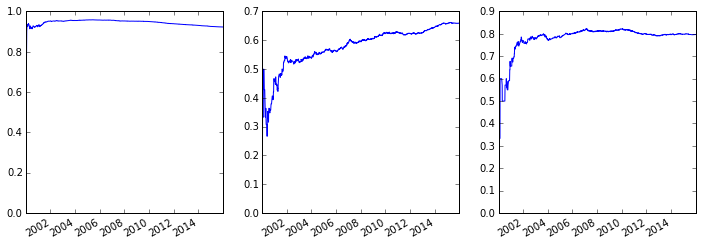

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(t_window, accuracy)
plt.subplot(1,3,2)
plt.plot(t_window, recall)
plt.subplot(1,3,3)
plt.plot(t_window, precision)

print time.time() - start
plt.gcf().autofmt_xdate()

Now the interesting part: how do we observe concept drift?

Methods are taken from: http://www.win.tue.nl/~mpechen/publications/pubs/Gama_ACMCS_AdaptationCD_accepted.pdf

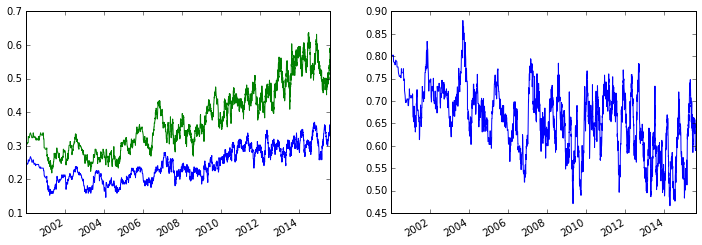

In [10]:
#SPC method

stepsize = 10
window = 500
actual_error = []
expected_error = []
t_error = []
for i in range(1, len(error) - window, stepsize):
    actual_error.append(np.std(error[i:(i+window)]))
    p = np.sum(y_train[i:(i+window)])*1./window
    expected_error.append(np.sqrt(p*(1+p)))
    t_error.append(t[i])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(t_error, actual_error)
plt.plot(t_error, expected_error)
plt.gcf().autofmt_xdate()
plt.subplot(1,2,2)
plt.plot(t_error, np.array(actual_error)/np.array(expected_error))
plt.gcf().autofmt_xdate()

In [11]:
with open("predict_journal_sgd1-all.json", "w") as f:
    pickle.dump({'t': t,
                 'y_train': y_train,
                 'y_predict': y_predict}, f)